In [1]:
!pip install opencv-python


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the notebook
%matplotlib inline

In [3]:
def gamma_correction(img, gamma):
    """
    Applies gamma correction: s = c * r^gamma
    """
    # Create a lookup table (LUT) for speed
    # We normalize 0-255 to 0-1, apply gamma, then scale back
    table = np.array([((i / 255.0) ** gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply LUT
    return cv2.LUT(img, table)

def contrast_stretching(img, r1, r2):
    """
    Applies piecewise linear contrast stretching.
    s(r) = 0                       if r < r1
    s(r) = (r - r1) / (r2 - r1)    if r1 <= r <= r2
    s(r) = 1                       if r > r2
    Input r is expected to be normalized [0, 1] for the logic, 
    but we handle the 0-255 uint8 conversion inside.
    """
    # Convert to float [0, 1] for easy calculation
    img_float = img.astype(np.float32) / 255.0
    output = np.zeros_like(img_float)
    
    # Vectorized masking (efficient implementation)
    
    # 1. Range: r1 <= r <= r2
    mask_middle = (img_float >= r1) & (img_float <= r2)
    output[mask_middle] = (img_float[mask_middle] - r1) / (r2 - r1)
    
    # 2. Range: r > r2
    mask_high = img_float > r2
    output[mask_high] = 1.0
    
    # 3. Range: r < r1 is already 0.0 (from np.zeros_like)

    # Scale back to [0, 255]
    return (output * 255).astype(np.uint8)

Images saved correctly.


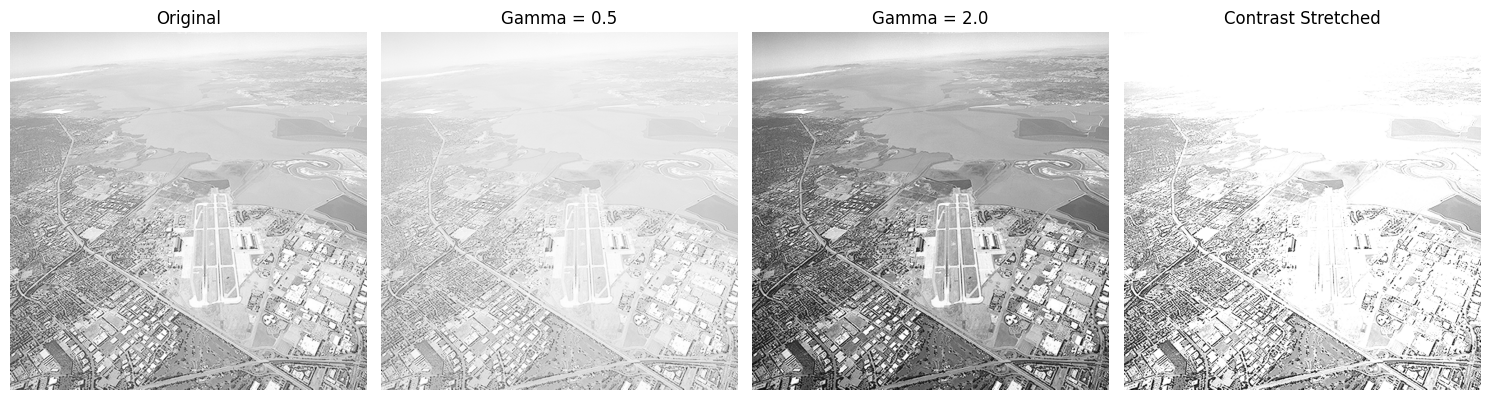

In [4]:
import os

# Load image in Grayscale
img_path = '../images/runway.png'
img = cv2.imread(img_path)

if img is None:
    print(f"Error: Could not load image from {img_path}. Check the file path.")
else:
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Apply transforms
    gamma_05 = gamma_correction(img_gray, gamma=0.5)
    gamma_20 = gamma_correction(img_gray, gamma=2.0)
    contrast_stretched = contrast_stretching(img_gray, r1=0.2, r2=0.8)

    # --- Saving (Use OpenCV/BGR) ---
    output_dir = '../images/outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    cv2.imwrite(os.path.join(output_dir, 'q1_runway_gamma_05.jpg'), gamma_05)
    cv2.imwrite(os.path.join(output_dir, 'q1_runway_gamma_20.jpg'), gamma_20)
    cv2.imwrite(os.path.join(output_dir, 'q1_runway_contrast_stretched.jpg'), contrast_stretched)
    print("Images saved correctly.")

    # --- Plotting (Convert to RGB for Matplotlib) ---
    # Since these are grayscale, we just need to tell matplotlib it's 'gray'
    # If they were color, we would use: img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))

    images = [img_gray, gamma_05, gamma_20, contrast_stretched]
    titles = ['Original', 'Gamma = 0.5', 'Gamma = 2.0', 'Contrast Stretched']

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

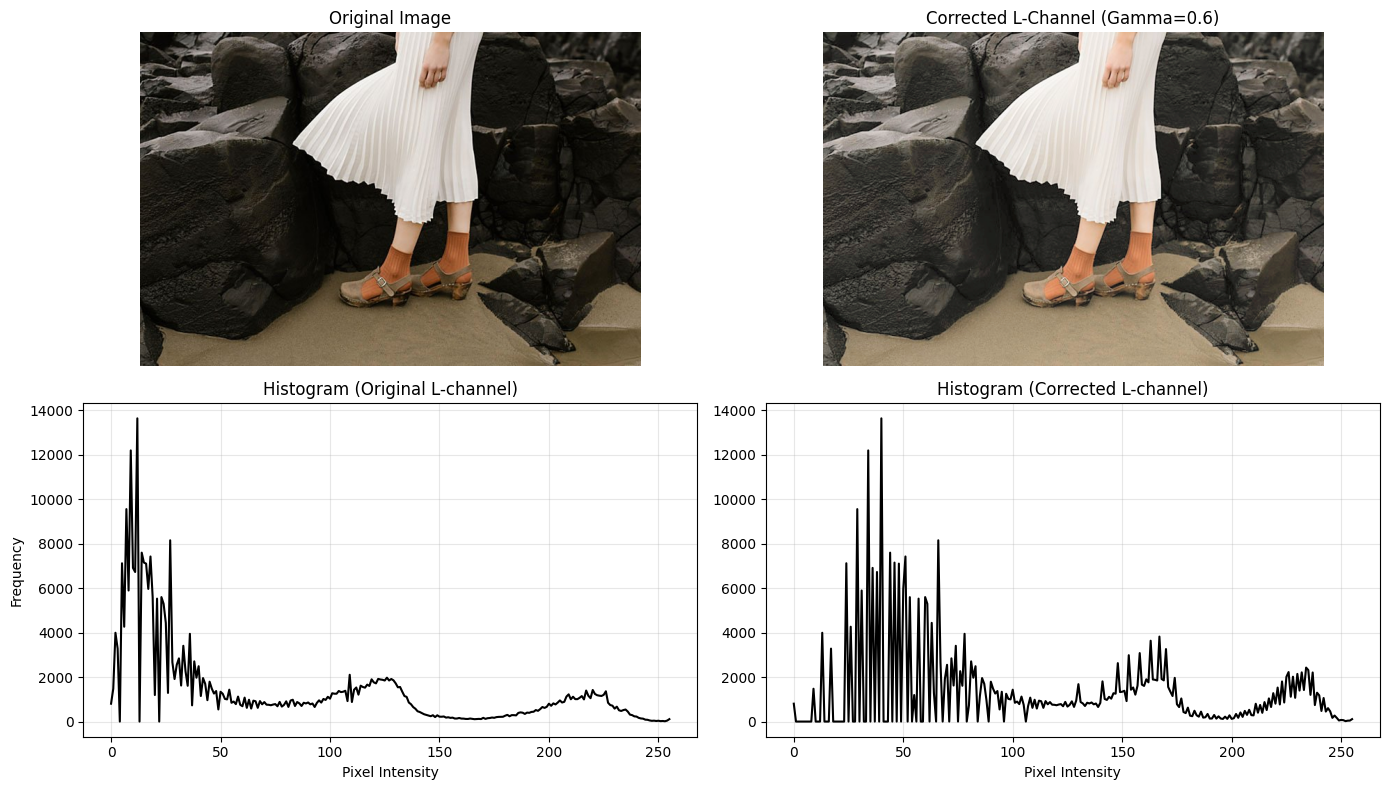

Q2 Result saved to: ../images/outputs\q2_girl_lab_corrected.jpg


In [5]:
img_path_q2 = '../images/highlights_and_shadows.jpg'  # Make sure file extension matches yours
img_bgr = cv2.imread(img_path_q2)

if img_bgr is None:
    print(f"Error: Could not load {img_path_q2}")
else:
    # 2. Convert from BGR to LAB
    lab_image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

    # 3. Split into channels (L=Lightness, A=Green-Red, B=Blue-Yellow)
    l, a, b = cv2.split(lab_image)

    # 4. Apply Gamma Correction to L-channel ONLY
    # We reuse the function 'gamma_correction' you defined in Cell 02
    gamma_val = 0.6  # Adjust this value as needed (e.g., 0.5 or 2.0)
    l_corrected = gamma_correction(l, gamma=gamma_val)

    # 5. Merge channels back together
    lab_corrected = cv2.merge((l_corrected, a, b))

    # 6. Convert back to BGR for visualization and saving
    img_corrected_bgr = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)

    # --- HISTOGRAMS (Required for Q2b) ---
    # Calculate histograms for the L-channel (Original vs Corrected)
    hist_original = cv2.calcHist([l], [0], None, [256], [0, 256])
    hist_corrected = cv2.calcHist([l_corrected], [0], None, [256], [0, 256])

    # --- VISUALIZATION ---
    plt.figure(figsize=(14, 8))

    # Convert BGR to RGB for Matplotlib plotting
    img_rgb_original = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb_corrected = cv2.cvtColor(img_corrected_bgr, cv2.COLOR_BGR2RGB)

    # Plot Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(img_rgb_original)
    plt.title('Original Image')
    plt.axis('off')

    # Plot Corrected Image
    plt.subplot(2, 2, 2)
    plt.imshow(img_rgb_corrected)
    plt.title(f'Corrected L-Channel (Gamma={gamma_val})')
    plt.axis('off')

    # Plot Histogram Original
    plt.subplot(2, 2, 3)
    plt.plot(hist_original, color='black')
    plt.title('Histogram (Original L-channel)')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Plot Histogram Corrected
    plt.subplot(2, 2, 4)
    plt.plot(hist_corrected, color='black')
    plt.title(f'Histogram (Corrected L-channel)')
    plt.xlabel('Pixel Intensity')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # --- SAVE OUTPUT ---
    # Define output directory
    output_dir = '../images/outputs'
    
    # Save the result
    save_path = os.path.join(output_dir, 'q2_girl_lab_corrected.jpg')
    cv2.imwrite(save_path, img_corrected_bgr)
    print(f"Q2 Result saved to: {save_path}")

In [7]:
def manual_histogram_equalization(img):
    # Calculate Histogram (Count frequency of each pixel intensity 0-255)
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    # Calculate CDF (Cumulative Distribution Function)
    cdf = hist.cumsum()
    # Normalize CDF to range [0, 255]
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')
    # Map original pixels to new values using the CDF as a lookup table
    img_equalized = cdf_final[img]
    return img_equalized

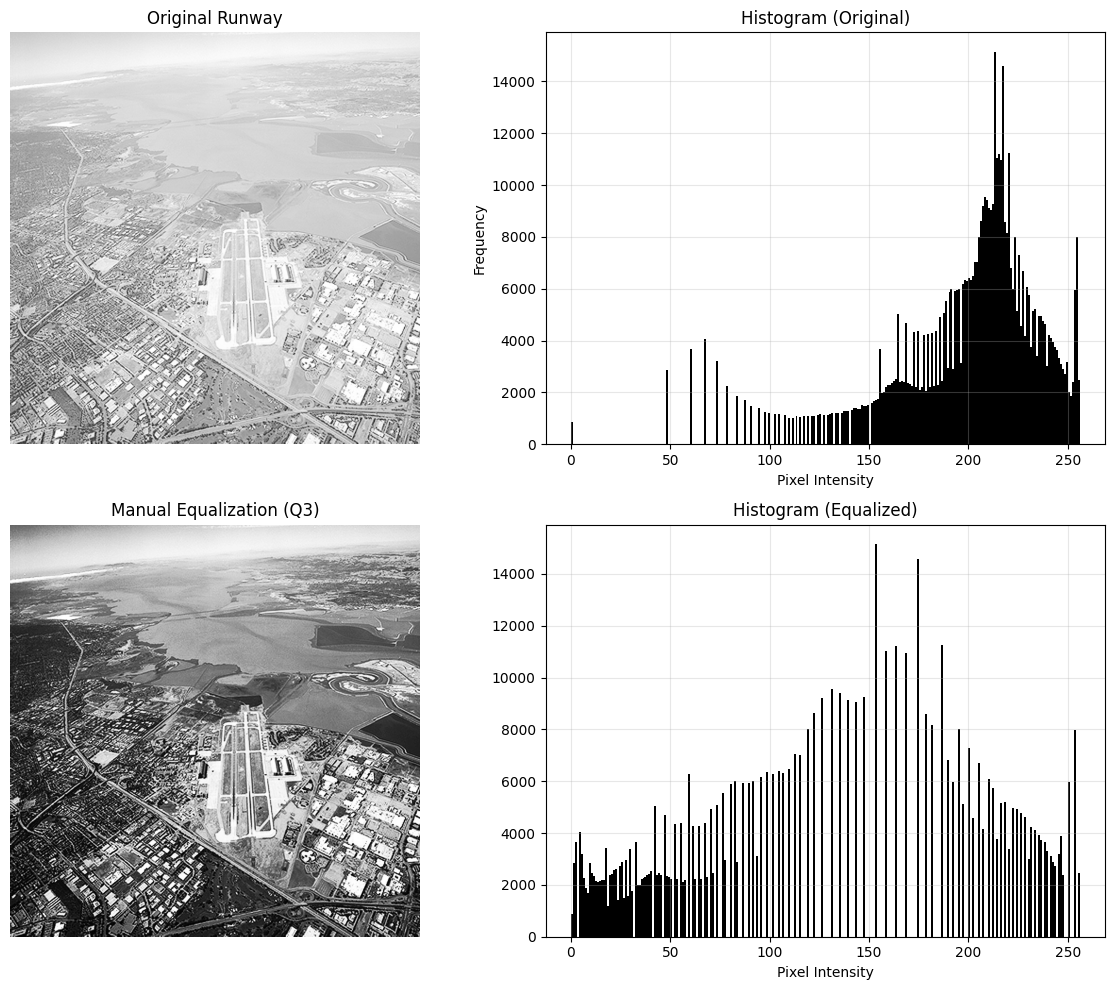

Q3 Result saved to: ../images/outputs\q3_runway_equalized.jpg


In [9]:
img_path_q3 = '../images/runway.png'
img = cv2.imread(img_path_q3, cv2.IMREAD_GRAYSCALE)

if img is None:
    print(f"Error: Could not load {img_path_q3}")
else:
    # Apply our manual function
    manual_eq_img = manual_histogram_equalization(img)
    
    # Validation: Compare with OpenCV's built-in function
    opencv_eq_img = cv2.equalizeHist(img)

    plt.figure(figsize=(12, 10))

    # 1. Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title('Original Runway')
    plt.axis('off')

    # 2. Histogram of Original
    plt.subplot(2, 2, 2)
    plt.hist(img.flatten(), bins=256, range=[0, 256], color='black')
    plt.title('Histogram (Original)')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # 3. Manual Equalized Image
    plt.subplot(2, 2, 3)
    plt.imshow(manual_eq_img, cmap='gray', vmin=0, vmax=255)
    plt.title('Manual Equalization (Q3)')
    plt.axis('off')
    
    # 4. Histogram of Equalized Result
    plt.subplot(2, 2, 4)
    plt.hist(manual_eq_img.flatten(), bins=256, range=[0, 256], color='black')
    plt.title('Histogram (Equalized)')
    plt.xlabel('Pixel Intensity')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Save Output
    output_dir = '../images/outputs'
    save_path = os.path.join(output_dir, 'q3_runway_equalized.jpg')
    cv2.imwrite(save_path, manual_eq_img)
    print(f"Q3 Result saved to: {save_path}")